using titanic.csv:

Load the data and observe some features
Break into a random 80/20 train test split
Fit a decision tree using the independent variables 'pclass + sex + age + sibsp' and the dependent variable 'survived'
Plot the full tree
Makre sure 'survived' is a qualitatie variable taking 1 (yes) or 0 (no) 

Print the performance measures of the full model:
    In-sample accuracy
    Out-of-sample accuracy
Defined by: 
    In-sample percent survivors correctly predicted (on training set)
    In-sample percent fatalities correctly predicted (on training set)
    Out-of-sample percent survivors correctly predicted (on test set)
    Out-of-sample percent fatalities correctly predicted (on test set)
    
Use cross-validation to find the best parameters to prune the tree. 
Plot a graph with 'tree-size' as the x-axis and 'number of misclassifications' as the y-axis. 
Find the optimum tree size based off of the misclassification rate

Prune the tree to the optimal size. Plot the pruned tree

In [1]:
import os
import subprocess
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.data as tfds
import matplotlib.pyplot as pt

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report
from IPython.display import Image

from tqdm import tqdm

### Load the dataframe from Titanic.csv and explore

In [2]:
datapath: str = os.path.join('data', 'Titanic.csv')

In [3]:
df: pd.DataFrame = pd.read_csv(datapath)

In [4]:
df.head()

,Unnamed: 0,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1st,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.337494,B5,Southampton,2,NaN,"St Louis, MO"
1,2,1st,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.550003,C22 C26,Southampton,11,NaN,"Montreal, PQ / Chesterville, ON"
2,3,1st,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,4,1st,0,"Allison, Mr. Hudson Joshua Crei",male,30.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,5,1st,0,"Allison, Mrs. Hudson J C (Bessi",female,25.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [5]:
df.describe()

,Unnamed: 0,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,655.000000,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,378.020061,0.486055,14.413500,1.041658,0.865560,51.758669,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,328.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,655.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,982.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,1309.000000,1.000000,80.000000,8.000000,9.000000,512.329224,328.000000


In [6]:
df = df.drop(["Unnamed: 0", "name", "parch", "fare", "body", "embarked", "boat", "home.dest", "cabin", "ticket"], axis=1)
df.head()

,pclass,survived,sex,age,sibsp
0,1st,1,female,29.0000,0
1,1st,1,male,0.9167,1
2,1st,0,female,2.0000,1
3,1st,0,male,30.0000,1
4,1st,0,female,25.0000,1


In [7]:
df.isna().sum()

pclass        0
survived      0
sex           0
age         263
sibsp         0
dtype: int64

In [8]:
df['age'].fillna(value=df['age'].mean(), inplace=True)

In [9]:
df.isna().sum()

pclass      0
survived    0
sex         0
age         0
sibsp       0
dtype: int64

<AxesSubplot:>

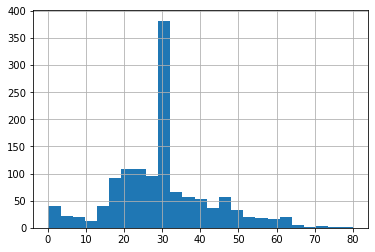

In [10]:
df.age.hist(bins=25)

<AxesSubplot:>

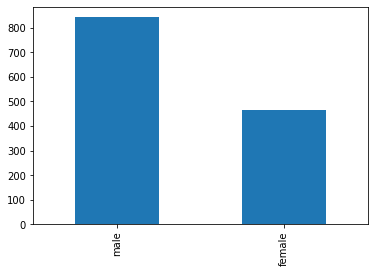

In [11]:
df.sex.value_counts().plot(kind='bar')

<AxesSubplot:>

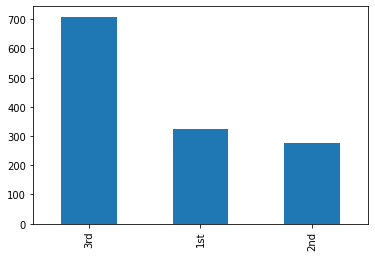

In [12]:
df.pclass.value_counts().plot(kind='bar')

<AxesSubplot:>

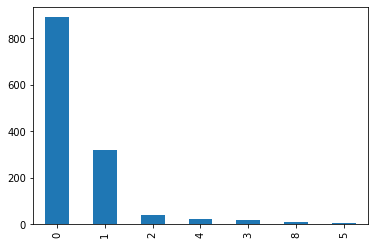

In [13]:
df.sibsp.value_counts().plot(kind='bar')

<AxesSubplot:>

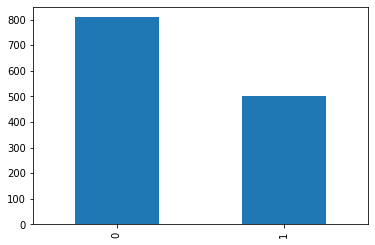

In [14]:
df.survived.value_counts().plot(kind='bar')

In [15]:
df['sex'] = df['sex'].astype('category')
sex_categories = df['sex'].cat.categories.tolist()
df['pclass'] = df['pclass'].astype('category')
pclass_categories = df['pclass'].cat.categories.tolist()
df['sex'] = df['sex'].cat.codes
df['pclass'] = df['pclass'].cat.codes

In [16]:
df.head()

,pclass,survived,sex,age,sibsp
0,0,1,0,29.0000,0
1,0,1,1,0.9167,1
2,0,0,0,2.0000,1
3,0,0,1,30.0000,1
4,0,0,0,25.0000,1


In [17]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   int8   
 1   survived  1309 non-null   int64  
 2   sex       1309 non-null   int8   
 3   age       1309 non-null   float64
 4   sibsp     1309 non-null   int64  
dtypes: float64(1), int64(2), int8(2)
memory usage: 33.4 KB
None


### Initial training of the model as a baseline

In [18]:
def prepare(df, target, val_percent, test_percent, shuffle=True):
    assert 0 < test_percent < 1.
    
    num_test = round(len(df) * test_percent)
    y = df.loc[:, df.columns == target]
    x = df.loc[:, df.columns != target]
    
    X, x_test, y, y_test = train_test_split(x, y, test_size=test_percent, shuffle=shuffle)
        
    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=val_percent)
    
    return x_train, y_train, x_val, y_val, x_test, y_test

In [19]:
x_train, y_train, x_val, y_val, x_test, y_test = prepare(df, 'survived', 0.2, 0.2, shuffle=True)

In [20]:
dtc = DecisionTreeClassifier(random_state=42,
                                 criterion='entropy', 
                                 splitter='best',
                                 max_depth=3,
                                 min_samples_split=5,
                                 min_samples_leaf=1,
                                 max_leaf_nodes=5,
                                 min_impurity_decrease=0)

In [21]:
dtc.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, max_leaf_nodes=5,
                       min_impurity_decrease=0, min_samples_split=5,
                       random_state=42)

In [22]:
export_graphviz(dtc, out_file='tree.dot', feature_names=x_train.columns)

In [23]:
bashCommand = 'dot -Tpng tree.dot -o tree.png'
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
output, error = process.communicate()

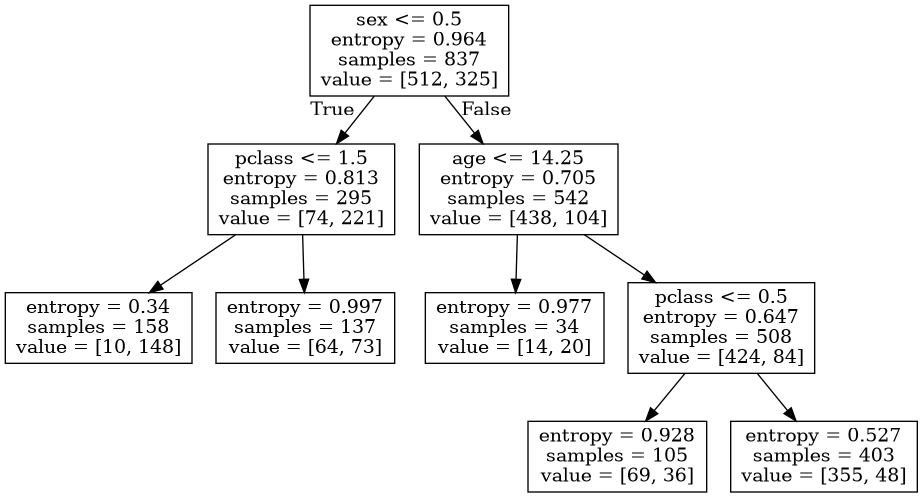

In [24]:
Image('tree.png')

In [25]:
dtc.score(x_test, y_test)

0.7366412213740458

In [26]:
y_pred = dtc.predict(x_train)
print(classification_report(y_pred, y_train))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       508
           1       0.74      0.73      0.74       329

    accuracy                           0.79       837
   macro avg       0.78      0.78      0.78       837
weighted avg       0.79      0.79      0.79       837



In [27]:
criterion = ['entropy']
splitter = ['best']
max_depth = [None, 1, 2, 3, 4]
min_samples_split = [2, 4, 6]
min_samples_leaf = [1, 3, 5]
max_leaf_nodes = [None, 3, 5]
min_impurity_decrease = [0, 0.2, 0.3, 0.5]

param_grid = {
    'criterion'               : criterion,
    'splitter'                : splitter,
    'max_depth'               : max_depth,
    'min_samples_split'       : min_samples_split,
    'min_samples_leaf'        : min_samples_leaf,
    'max_leaf_nodes'          : max_leaf_nodes,
    'min_impurity_decrease'   : min_impurity_decrease
}

cls_scores = []
gsearch = GridSearchCV(dtc, param_grid, verbose=1)
gsearch.fit(x_train, y_train)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


GridSearchCV(estimator=DecisionTreeClassifier(criterion='entropy', max_depth=3,
                                              max_leaf_nodes=5,
                                              min_impurity_decrease=0,
                                              min_samples_split=5,
                                              random_state=42),
             param_grid={'criterion': ['entropy'],
                         'max_depth': [None, 1, 2, 3, 4],
                         'max_leaf_nodes': [None, 3, 5],
                         'min_impurity_decrease': [0, 0.2, 0.3, 0.5],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 4, 6], 'splitter': ['best']},
             verbose=1)

In [28]:
gsearch.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=4,
                       min_impurity_decrease=0, random_state=42)

In [29]:
gsearch.best_score_

0.813622754491018

In [30]:
gsearch.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'best'}

In [31]:
gsearch.scorer_

<function sklearn.metrics._scorer._passthrough_scorer(estimator, *args, **kwargs)>

In [32]:
results = pd.DataFrame(gsearch.cv_results_)

In [33]:
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_leaf_nodes,param_min_impurity_decrease,param_min_samples_leaf,param_min_samples_split,param_splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005427,0.001560,0.002072,0.000429,entropy,None,None,0,1,2,best,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.785714,0.779762,0.772455,0.778443,0.790419,0.781359,0.006187,54
1,0.004643,0.000742,0.001609,0.000151,entropy,None,None,0,1,4,best,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.791667,0.797619,0.772455,0.778443,0.808383,0.789713,0.012960,26
2,0.004208,0.000184,0.001643,0.000184,entropy,None,None,0,1,6,best,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.797619,0.815476,0.778443,0.766467,0.796407,0.790883,0.016921,22
3,0.004022,0.000160,0.001521,0.000050,entropy,None,None,0,3,2,best,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.821429,0.791667,0.796407,0.760479,0.784431,0.790883,0.019648,23
4,0.004091,0.000094,0.001674,0.000190,entropy,None,None,0,3,4,best,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.821429,0.791667,0.796407,0.760479,0.784431,0.790883,0.019648,23


0    0.781359
Name: mean_test_score, dtype: float64
108    0.787418
Name: mean_test_score, dtype: float64
216    0.76348
Name: mean_test_score, dtype: float64
324    0.794539
Name: mean_test_score, dtype: float64
432    0.813623
Name: mean_test_score, dtype: float64


Text(0, 0.5, 'misclassifications')

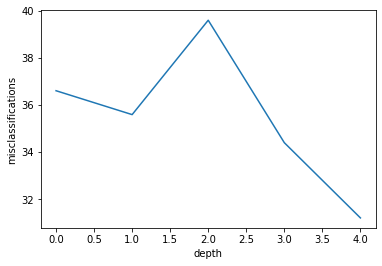

In [34]:
misclass_counts = []

best = gsearch.best_params_
for value in max_depth:
    reults = results.loc[results.param_criterion.isin([best['criterion']])]
    results = results.loc[results.param_max_leaf_nodes.isin([best['max_leaf_nodes']])]
    results = results.loc[results.param_min_impurity_decrease.isin([best['min_impurity_decrease']])]
    results = results.loc[results.param_min_samples_leaf.isin([best['min_samples_leaf']])]
    results = results.loc[results.param_min_samples_split.isin([best['min_samples_split']])]
    results = results.loc[results.param_splitter.isin([best['splitter']])]
    parsed = results.loc[results.param_max_depth.isin((value,))]
    print(parsed["mean_test_score"])
    mis = (1 - parsed['mean_test_score']) * len(y_train)/5
    misclass_counts.append(mis)
    
# for score in gsearch.cv_results_['mean_test_score'][1:]:
#     if np.isnan(score):
#         score=0
    
        
# misclass_counts.append(int((1-score) * 5))

pt.plot(range(len(max_depth)), misclass_counts)
pt.xlabel("depth")
pt.ylabel("misclassifications")

### The Decision Tree with the best GridSearchCV Score

In [35]:
best_dt = DecisionTreeClassifier(random_state=42,
                                    **gsearch.best_params_)

In [36]:
best_dt.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4,
                       min_impurity_decrease=0, random_state=42)

In [37]:
export_graphviz(best_dt, out_file='best_tree.dot', feature_names=x_train.columns)

In [38]:
bashCommand = 'dot -Tpng best_tree.dot -o best_tree.png'
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
output, error = process.communicate()

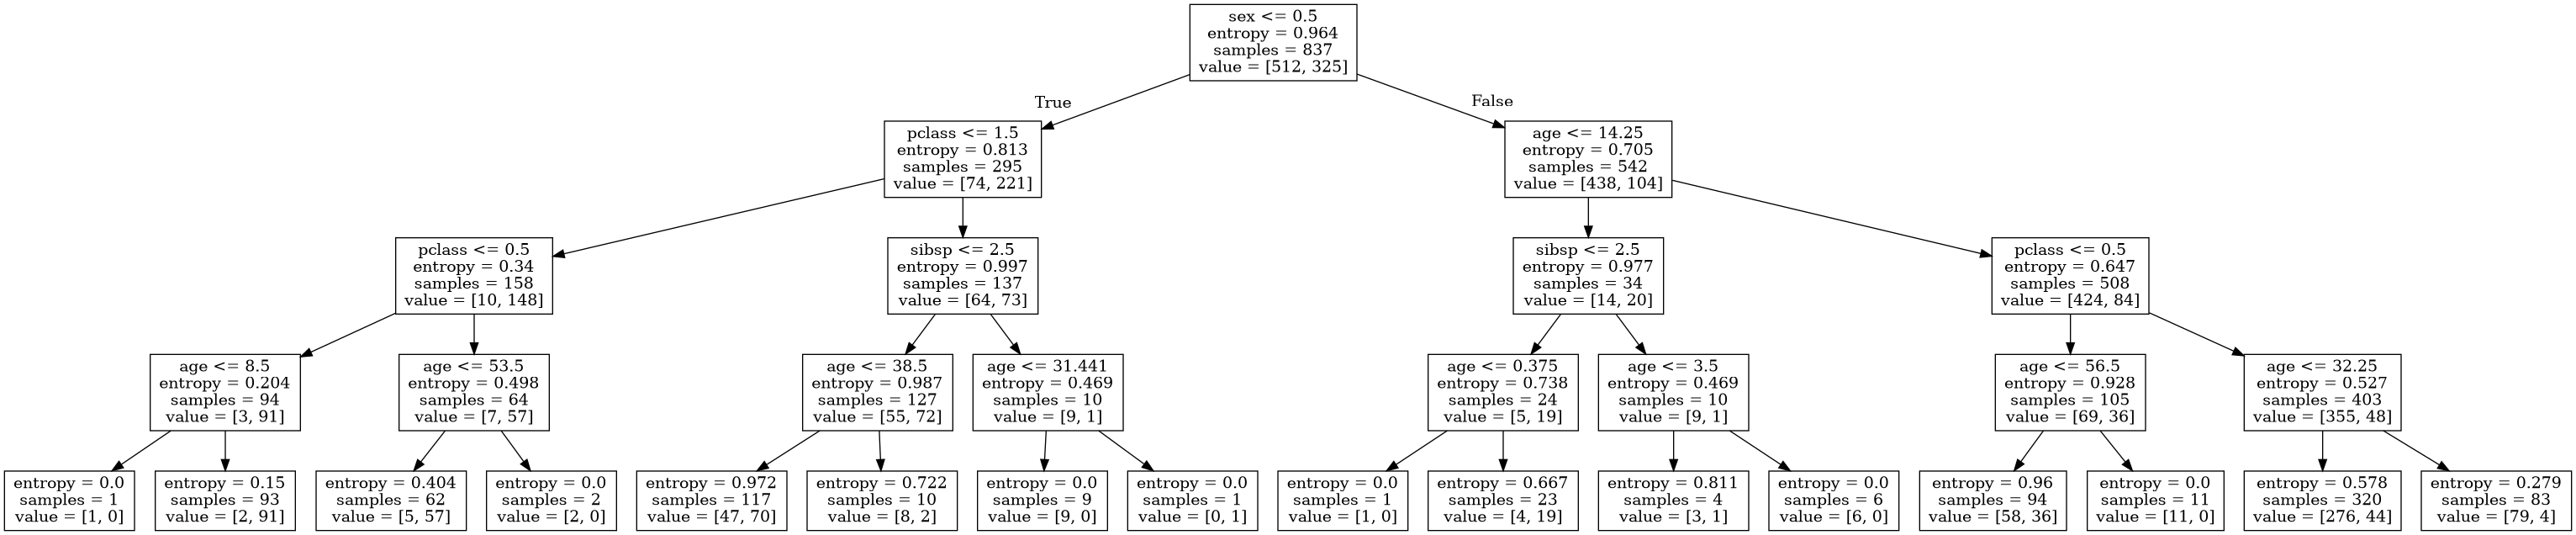

In [39]:
Image('best_tree.png')

In [40]:
y_pred = best_dt.predict(x_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83       181
           1       0.62      0.72      0.66        81

    accuracy                           0.77       262
   macro avg       0.74      0.76      0.75       262
weighted avg       0.79      0.77      0.78       262



In [41]:
best_dt.score(x_test, y_test)

0.7748091603053435